In [1]:
# import all the libraries
import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

# import python scripts we created to help with feature engineering
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.helpers import identify_highly_correlated_features, one_hot, identify_low_variance_features, identify_missing_data, feature_importance_plot
from src.learning_curve_plot import learning_curve_plot


In [2]:
housing_df = pd.read_csv("../data/housing_df.csv")
housing_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,target
0,60.0,RL,65.0,8450.0,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,2.0,2008.0,208500.0
1,20.0,RL,80.0,9600.0,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,5.0,2007.0,181500.0
2,60.0,RL,68.0,11250.0,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,9.0,2008.0,223500.0
3,70.0,RL,60.0,9550.0,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,2.0,2006.0,140000.0
4,60.0,RL,84.0,14260.0,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,12.0,2008.0,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60.0,RL,62.0,7917.0,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,8.0,2007.0,175000.0
1456,20.0,RL,85.0,13175.0,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,0.0,0.0,NaN,MnPrv,NaN,0.0,2.0,2010.0,210000.0
1457,70.0,RL,66.0,9042.0,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,0.0,0.0,NaN,GdPrv,Shed,2500.0,5.0,2010.0,266500.0
1458,20.0,RL,68.0,9717.0,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,4.0,2010.0,142125.0


### Explore the Data

In [3]:
pd.set_option('display.max_columns', None) # you can use this code to view all columns

housing_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,BldgType,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,target
0,60.0,RL,65.0,8450.0,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,1Fam,7.0,5.0,2003.0,2003.0,BrkFace,196.0,Gd,TA,Gd,TA,No,706.0,0.0,150.0,856.0,Ex,Y,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,8.0,0.0,2003.0,RFn,2.0,548.0,Y,0.0,61.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,2.0,2008.0,208500.0
1,20.0,RL,80.0,9600.0,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,1Fam,6.0,8.0,1976.0,1976.0,None,0.0,TA,TA,Gd,TA,Gd,978.0,0.0,284.0,1262.0,Ex,Y,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,TA,6.0,1.0,1976.0,RFn,2.0,460.0,Y,298.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,5.0,2007.0,181500.0
2,60.0,RL,68.0,11250.0,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,1Fam,7.0,5.0,2001.0,2002.0,BrkFace,162.0,Gd,TA,Gd,TA,Mn,486.0,0.0,434.0,920.0,Ex,Y,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,6.0,1.0,2001.0,RFn,2.0,608.0,Y,0.0,42.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,9.0,2008.0,223500.0
3,70.0,RL,60.0,9550.0,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,1Fam,7.0,5.0,1915.0,1970.0,None,0.0,TA,TA,TA,Gd,No,216.0,0.0,540.0,756.0,Gd,Y,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,Gd,7.0,1.0,1998.0,Unf,3.0,642.0,Y,0.0,35.0,272.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,2.0,2006.0,140000.0
4,60.0,RL,84.0,14260.0,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,1Fam,8.0,5.0,2000.0,2000.0,BrkFace,350.0,Gd,TA,Gd,TA,Av,655.0,0.0,490.0,1145.0,Ex,Y,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,Gd,9.0,1.0,2000.0,RFn,3.0,836.0,Y,192.0,84.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,12.0,2008.0,250000.0


In [4]:
# check the shape of the data

housing_df.shape

# that's a lot of columns! We have data on 1460 houses.

(1460, 60)

In [5]:
# check the info of the data

housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 60 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   float64
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   float64
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  BldgType       1460 non-null   object 
 12  OverallQual    1460 non-null   float64
 13  OverallCond    1460 non-null   float64
 14  YearBuilt      1460 non-null   float64
 15  YearRemodAdd   1460 non-null   float64
 16  MasVnrType     1452 non-null   object 
 17  MasVnrArea     1452 non-null   float64
 18  ExterQua

In [6]:
# identify features with low std

identify_low_variance_features(housing_df, std_threshold=0.01)

number of low variance features: 0
low variance features: []


/Users/shaq/private/ip302/src/helpers.py:116: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std_df = pd.DataFrame(df.std()).rename(columns = {0: 'standard_deviation'})


[]

/Users/shaq/.pyenv/versions/3.8.10/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


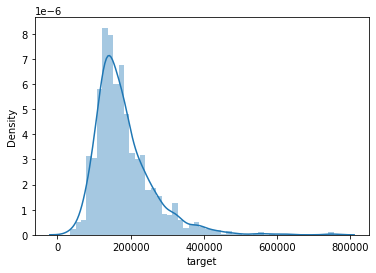

In [7]:
# check the distribution of the target

sns.distplot(housing_df.target);

# question: do you see any skew in the data?

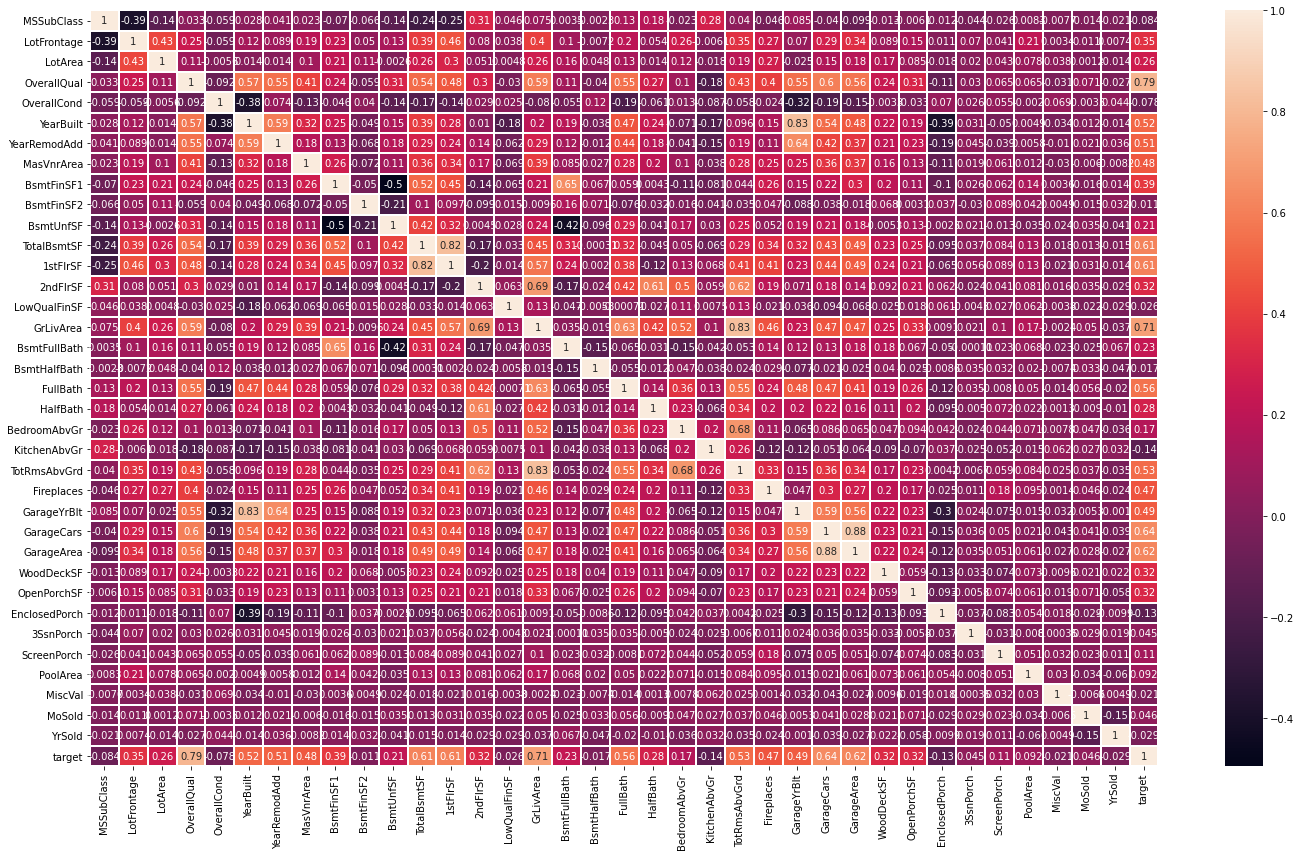

In [8]:
# look at highly correlated variables

plt.figure(figsize=(20,12))
sns.heatmap(housing_df.corr(),annot=True, linewidth=2)
plt.tight_layout()


In [9]:
identify_highly_correlated_features(housing_df, correlation_threshold=0.85)

# we have one highly correlated feature which we will drop in the feature engineering section

,corr_feature,drop_feature,correlation_values
0,GarageCars,GarageArea,0.88


In [10]:
# visualising the target which is a continuous variable

housing_df.target.describe()

# some slight positive skew - this can be identified with the mode less than the median less than the mean

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: target, dtype: float64

In [11]:
print("mode of the housing_df", list(housing_df.target.mode()))

mode of the housing_df [140000.0]


/Users/shaq/.pyenv/versions/3.8.10/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


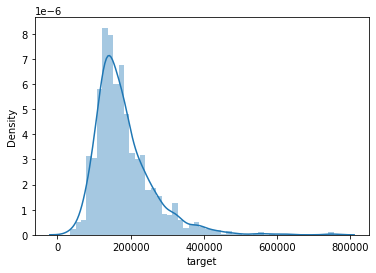

In [12]:
sns.distplot(housing_df.target);

# visualisation also shows signs of skew

/Users/shaq/.pyenv/versions/3.8.10/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


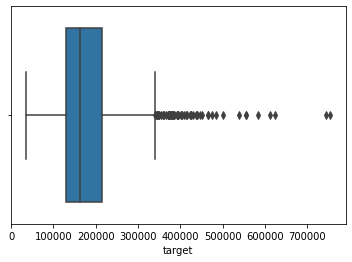

In [13]:
sns.boxplot(housing_df.target);

# outliers in target, which we may want to remove in a future iteration

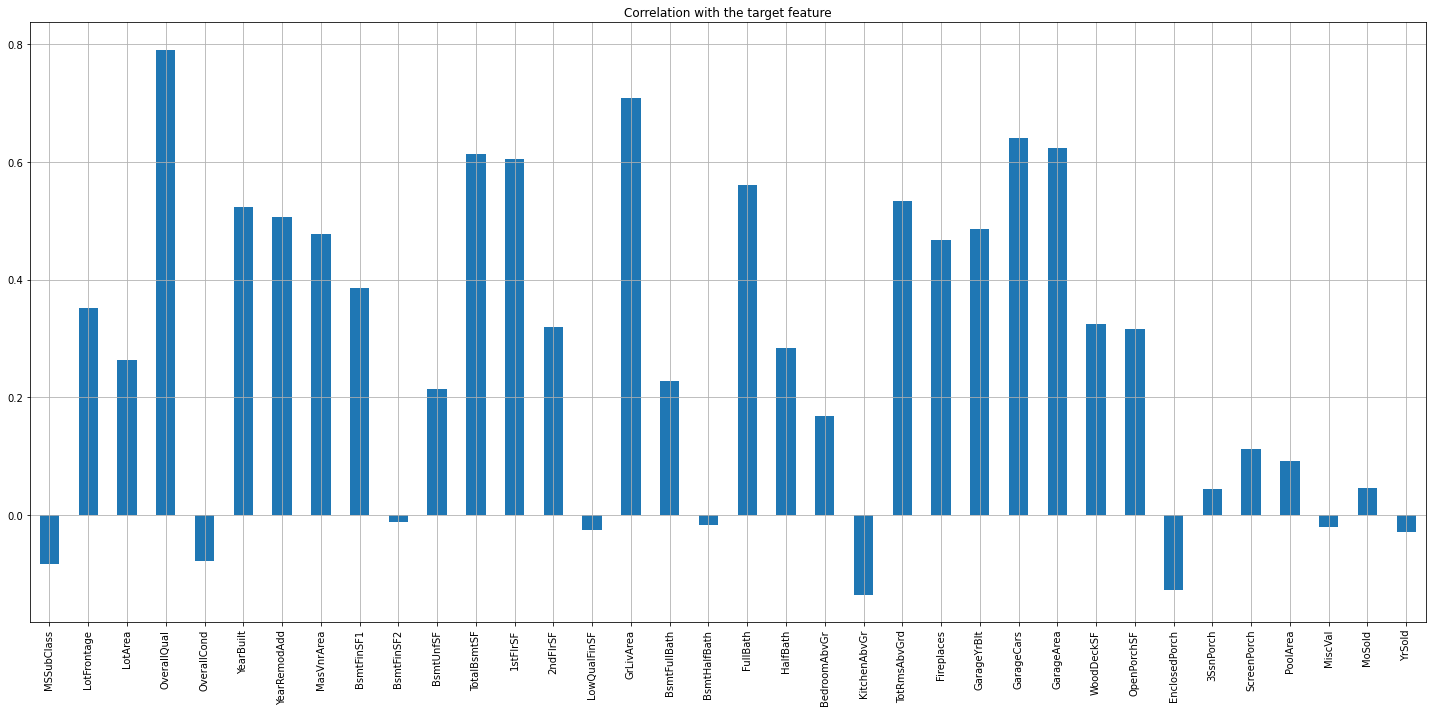

In [14]:
# Bonus

# identfiying features that are highly correlated with the target

housing_df.drop('target', axis=1).corrwith(housing_df.target).plot(kind='bar', grid=True, figsize=(20, 10), 
                                                        title="Correlation with the target feature")
plt.tight_layout()

# exang has the highest postive correlation, closely followed by oldpeak, slope and thal


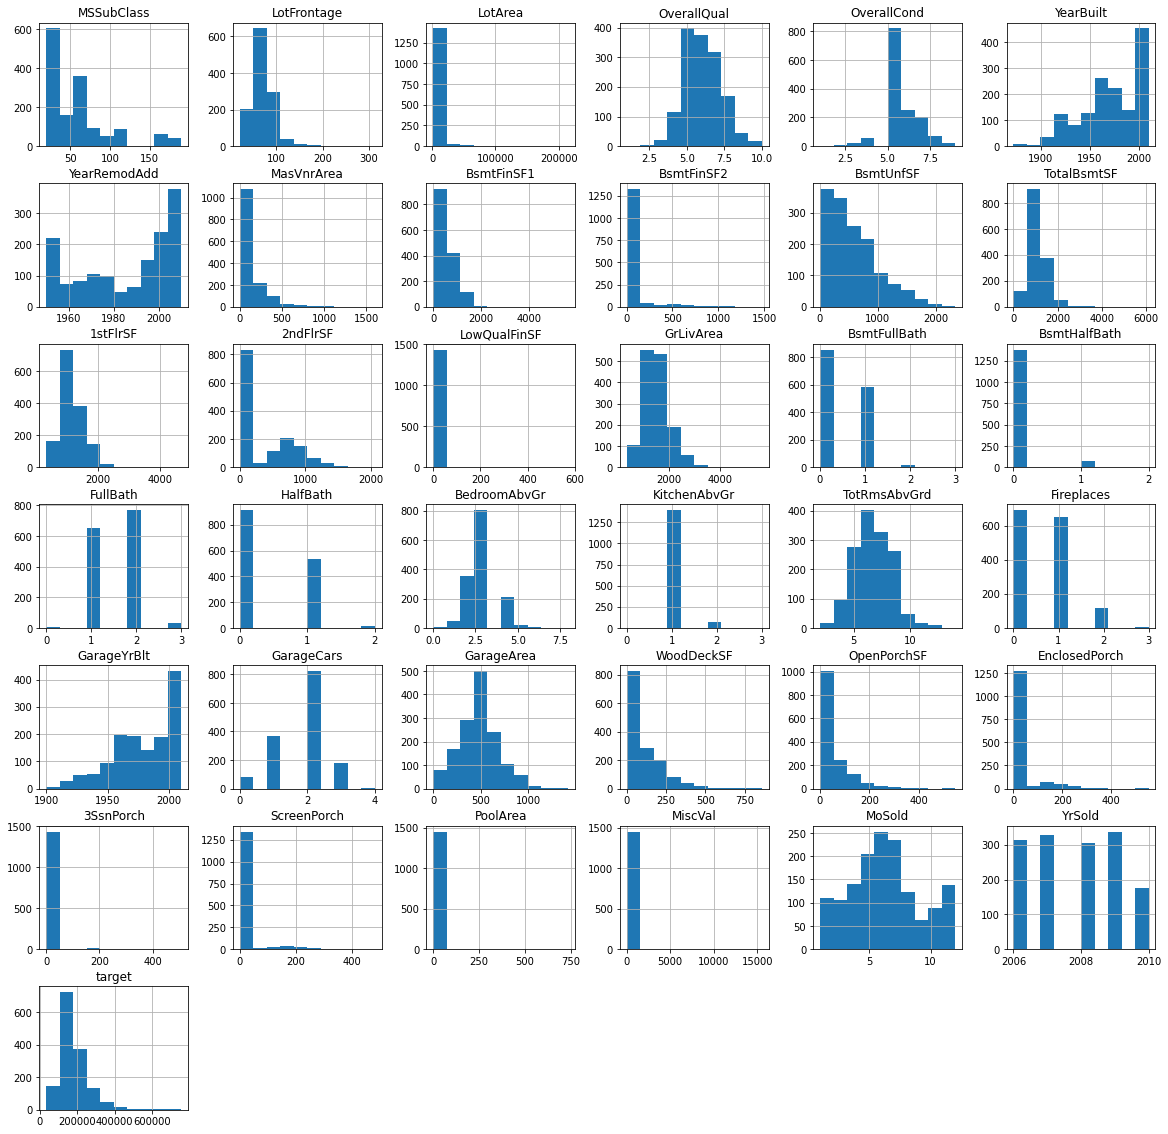

In [15]:
# what about the other numerical variables

plt.rcParams["figure.figsize"] = (20,20)

housing_df.hist();

# because of the amount of skewed data, please use tree based models only

In [16]:
# Identify missing data
# before doing any encoding, lets identify missing data

missing_value_df = identify_missing_data(housing_df) 
missing_value_df

,feature,percent_missing,data_type
0,PoolQC,99.52,object
1,MiscFeature,96.30,object
2,Alley,93.77,object
3,Fence,80.75,object
4,LotFrontage,17.74,float64
5,GarageFinish,5.55,object
6,GarageYrBlt,5.55,float64
7,BsmtExposure,2.60,object
8,BsmtQual,2.53,object
9,BsmtCond,2.53,object


In [17]:
print("# of features with missing values:", missing_value_df.shape[0])

# of features with missing values: 12


The goal of EDA is to understand the data and identify if we need to do any additional data cleaning or feature engineering.
- We do not have any features with low standard deviation, so we do not have drop any additional features
- We have one pair of highly correlated features (positive or negative), which we will drop when we do our feature engineering 
- We have 23 features with data type object, so we have to do additonal encoding in the feature engineering section
- We have 12 features with missing data, so we have to handle this

### Data Cleaning

In [18]:
# drop features which have more than 60% missing values
# identify features which have more than 60% missing data

threshold = 60

cols_to_drop = list(missing_value_df[missing_value_df.percent_missing > threshold].feature)
print("number of columns to drop:", len(cols_to_drop))
print(cols_to_drop)

number of columns to drop: 4
['PoolQC', 'MiscFeature', 'Alley', 'Fence']


In [19]:
# drop the features with more than 60% missing data

housing_df_cleaned = housing_df.drop(cols_to_drop, axis = 1)

# check the variables are dropped 
print(housing_df.shape)
print(housing_df_cleaned.shape)

(1460, 60)
(1460, 56)


In [20]:
# identify duplicates
# the data set has no duplicated data

housing_df_cleaned[housing_df_cleaned.duplicated(keep=False)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,BldgType,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,target


### Feature Engineering

In [21]:
# handling missing data
# reminder of missing data

missing_value_df = identify_missing_data(housing_df_cleaned)
missing_value_df

,feature,percent_missing,data_type
0,LotFrontage,17.74,float64
1,GarageYrBlt,5.55,float64
2,GarageFinish,5.55,object
3,BsmtExposure,2.60,object
4,BsmtCond,2.53,object
5,BsmtQual,2.53,object
6,MasVnrType,0.55,object
7,MasVnrArea,0.55,float64


In [22]:
# replace all categorical (data type object) missing values with Unknown --- Option 1 

housing_df_cleaned['GarageFinish'].fillna('Unknown', inplace=True)
housing_df_cleaned['BsmtExposure'].fillna('Unknown', inplace=True)
housing_df_cleaned['BsmtCond'].fillna('Unknown', inplace=True)
housing_df_cleaned['BsmtQual'].fillna('Unknown', inplace=True)
housing_df_cleaned['MasVnrType'].fillna('Unknown', inplace=True)


In [23]:
# replace all categorical (data type object) missing values with Unknown --- Option 2

missing_value_df = identify_missing_data(housing_df_cleaned)
categorical_cols = list(missing_value_df[missing_value_df.data_type == 'object'].feature)
print("number of categorical cols with missing data:", len(categorical_cols))
    
for c in categorical_cols:
    print("replacing missing values for:", c)
    housing_df_cleaned[c].fillna('Unknown', inplace=True)

number of categorical cols with missing data: 0


In [24]:
# look for missing data

missing_value_df = identify_missing_data(housing_df_cleaned)
missing_value_df

,feature,percent_missing,data_type
0,LotFrontage,17.74,float64
1,GarageYrBlt,5.55,float64
2,MasVnrArea,0.55,float64


In [25]:
# replace all numerical (data type object) missing values with Unknown --- Option 1 

housing_df_cleaned['LotFrontage'].fillna(0, inplace=True)
housing_df_cleaned['GarageYrBlt'].fillna(0, inplace=True)
housing_df_cleaned['MasVnrArea'].fillna(0, inplace=True)


In [26]:
# replace all numerical missing (data type int, float or bool) values with 0 --- Option 2
missing_value_df = identify_missing_data(housing_df)
numerical_cols = list(missing_value_df[(missing_value_df.data_type == 'float64') |(missing_value_df.data_type == 'int64')].feature)
print("number of numerical cols with missing data:", len(numerical_cols))

for n in numerical_cols:
    print("replacing missing values for:", n)
    housing_df_cleaned[n].fillna(0, inplace=True)

number of numerical cols with missing data: 3
replacing missing values for: LotFrontage
replacing missing values for: GarageYrBlt
replacing missing values for: MasVnrArea


In [27]:
# check do we have any missing data left

missing_value_df = identify_missing_data(housing_df_cleaned)
missing_value_df

,feature,percent_missing,data_type


In [28]:
# check the info as a reminder - we have 19 variables with object data type that needs encoding

housing_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 56 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   float64
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   float64
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  BldgType       1460 non-null   object 
 11  OverallQual    1460 non-null   float64
 12  OverallCond    1460 non-null   float64
 13  YearBuilt      1460 non-null   float64
 14  YearRemodAdd   1460 non-null   float64
 15  MasVnrType     1460 non-null   object 
 16  MasVnrArea     1460 non-null   float64
 17  ExterQual      1460 non-null   object 
 18  ExterCon

In [29]:
# identify how many categorical columns of data we have i.e. variables with data type object

categorical_cols = list(housing_df_cleaned.select_dtypes(['object']).columns)
print("number of categorical columns:", len(categorical_cols))

number of categorical columns: 19


In [30]:
# print the categorical cols

categorical_cols

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'BldgType',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'HeatingQC',
 'CentralAir',
 'KitchenQual',
 'GarageFinish',
 'PavedDrive']

In [31]:
# encode all the categorical data

categorical_columns = list(housing_df_cleaned.select_dtypes(['object']).columns) # identify all the categorical columns

housing_df_w_encoding = one_hot(housing_df_cleaned, categorical_columns)

# shape of the new dataframe
housing_df_w_encoding.shape

(1460, 114)

In [32]:
# check the info - do we have any categorical data left?
# we should only have floats and uint. If this is not the case, stop and go back

housing_df_w_encoding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 114 entries, MSSubClass to PavedDrive_Y
dtypes: float64(37), uint8(77)
memory usage: 531.9 KB


In [33]:
# drop correlated features

housing_df_final = housing_df_w_encoding.drop(['GarageArea'], axis = 1)

# you can also look at which features are highly correlated with target when making decision which feature to drop

In [34]:
# shape of the data went from 60 columns to 113 columns. We did not drop any rows of data.

print(housing_df.shape)
print(housing_df_final.shape)

(1460, 60)
(1460, 113)


In [35]:
# save the file

housing_df_final.to_pickle("../data/housing_df_final.pkl")

- We have handled all the missing data, encoded the 19 variables with data type object and dropped the correlated feature. 
- Since we have no missing data and non numerical data types, we are one step closer to building our ML models.

### Build the Decision Tree Model

In [36]:
# define the target and features

target = housing_df_final["target"]
features = housing_df_final.drop(["target"], axis = 1)

In [37]:
target.shape

(1460,)

In [38]:
features.shape

(1460, 112)

In [39]:
# split the data into train and test set

X_train, X_test, y_train, y_test = train_test_split(
                                                features, 
                                                target,
                                                test_size = 0.3, 
                                                random_state = 8)


In [40]:
# print the shape of the training data

print("Training Data")
print("Shape of X_train", X_train.shape)
print("Shape of y_train", y_train.shape)

Training Data
Shape of X_train (1022, 112)
Shape of y_train (1022,)


In [41]:
# print the shape of the test data 

print("Test Data")
print("Shape of X_test", X_test.shape)
print("Shape of y_test", y_test.shape)

Test Data
Shape of X_test (438, 112)
Shape of y_test (438,)


In [42]:
# Build a Decision Tree Model

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)


In [43]:
print("first five predicted values:", y_pred_dt[0:5])
print("first five actual values:", list(y_test[0:5]))

first five predicted values: [231500. 127500. 106000. 176000. 214500.]
first five actual values: [181000.0, 124500.0, 114500.0, 155000.0, 187500.0]


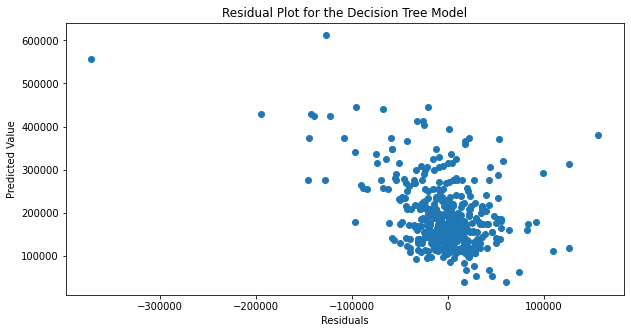

In [44]:
# residual plot

plt.rcParams["figure.figsize"] = (10,5)

residuals = y_test - y_pred_dt

plt.scatter(residuals, y_pred_dt)
plt.title("Residual Plot for the Decision Tree Model")
plt.xlabel("Residuals")
plt.ylabel("Predicted Value")
plt.show();

# we want them the points to be centred around 0

In [45]:
# the evaluation metrics for the model on the test set
r2 = r2_score(y_test, y_pred_dt)
print("R2:", round(r2, 2))
explained_var = explained_variance_score(y_test, y_pred_dt)
print("Explained Variance:", round(explained_var, 2))
mae = mean_absolute_error(y_test, y_pred_dt)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_test, y_pred_dt)
print("Mean Squared Error:", round(mse))

R2: 0.67
Explained Variance: 0.68
Mean Absolute Error: 26083
Mean Squared Error: 1721496044


In [46]:
# the evaluation metrics for the model on the training set

y_pred_train_dt = dt.predict(X_train)

r2 = r2_score(y_train, y_pred_train_dt)
print("R2:", round(r2, 2))
explained_var = explained_variance_score(y_train, y_pred_train_dt)
print("Explained Variance:", round(explained_var, 2))
mae = mean_absolute_error(y_train, y_pred_train_dt)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_train, y_pred_train_dt)
print("Mean Squared Error:", round(mse))

# seeing low error rates on the training set, in this case no error rate - signs of overfitting

R2: 1.0
Explained Variance: 1.0
Mean Absolute Error: 0
Mean Squared Error: 0


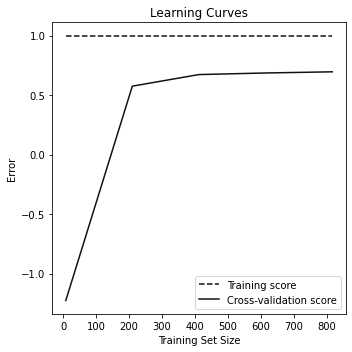

In [47]:
learning_curve_plot(dt, X_train, y_train, scoring = 'r2')

# what can we conclude about the decisiom tree model based on the learning curves?

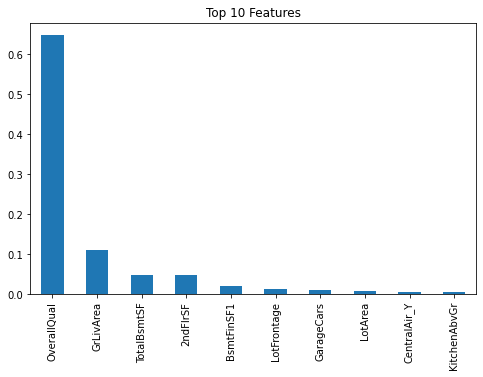

In [48]:
# feature importance plot

feature_importance_plot(dt, X_train, 10)

In [49]:
# what are the top 20 lowest features

feat_importances = pd.Series(dt.feature_importances_,
                                 index = X_train.columns)
feat_importance_df = pd.DataFrame(feat_importances).sort_values(by = 0).reset_index().rename(columns = {'index': 'feature',
                                                                                        0: 'score'})
feat_importance_df.head(20)

# we can see 18 features with no feature importance at all
# next iteration, we could remove features with no importance and see if this improves
# we could also consider a threshold for redundant features

,feature,score
0,LotConfig_FR3,0.0
1,Utilities_NoSeWa,0.0
2,ExterQual_Ex,0.0
3,MasVnrType_Unknown,0.0
4,MasVnrType_BrkCmn,0.0
5,MiscVal,0.0
6,BldgType_TwnhsE,0.0
7,BldgType_Twnhs,0.0
8,BldgType_2fmCon,0.0
9,MSZoning_RH,0.0


## Build a Random Forest Model

In [50]:
# Build a Random Forest Model

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [51]:
# the evaluation metrics for the model on the test set
r2 = r2_score(y_test, y_pred_rf)
print("R2:", round(r2, 2))
explained_var = explained_variance_score(y_test, y_pred_rf)
print("Explained Variance:", round(explained_var, 2))
mae = mean_absolute_error(y_test, y_pred_rf)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_test, y_pred_rf)
print("Mean Squared Error:", round(mse))

R2: 0.82
Explained Variance: 0.83
Mean Absolute Error: 17569
Mean Squared Error: 928408602


In [52]:
# the evaluation metrics for the model on the training set

y_pred_train_rf = rf.predict(X_train)

r2 = r2_score(y_train, y_pred_train_rf)
print("R2:", round(r2, 2))
explained_var = explained_variance_score(y_train, y_pred_train_rf)
print("Explained Variance:", round(explained_var, 2))
mae = mean_absolute_error(y_train, y_pred_train_rf)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_train, y_pred_train_rf)
print("Mean Squared Error:", round(mse))

# seeing low error rates on the training set, in this case no error rate - signs of overfitting

R2: 0.98
Explained Variance: 0.98
Mean Absolute Error: 6746
Mean Squared Error: 131366766


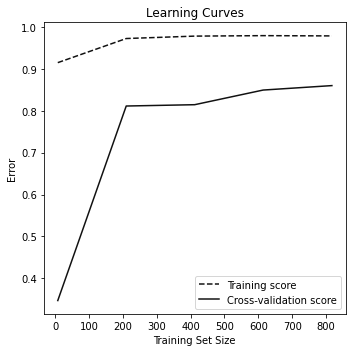

In [53]:
learning_curve_plot(rf, X_train, y_train, scoring = 'r2')

# what can we conclude about the random forest model based on the learning curves? less overfitting

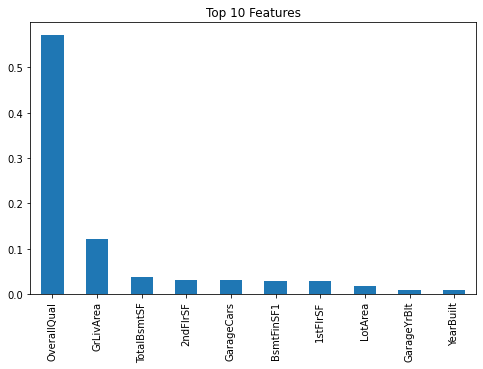

In [54]:
feature_importance_plot(rf, X_train, n = 10)

## Build a XGBoostModel

In [55]:
# Build a XGBoost

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [56]:
# the evaluation metrics for the model on the test set
r2 = r2_score(y_test, y_pred_xgb)
print("R2:", round(r2, 2))
explained_var = explained_variance_score(y_test, y_pred_xgb)
print("Explained Variance:", round(explained_var, 2))
mae = mean_absolute_error(y_test, y_pred_xgb)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_test, y_pred_xgb)
print("Mean Squared Error:", round(mse))

R2: 0.79
Explained Variance: 0.79
Mean Absolute Error: 18593
Mean Squared Error: 1129623708


In [57]:
# the evaluation metrics for the model on the training set

y_pred_train_xgb = xgb.predict(X_train)

r2 = r2_score(y_train, y_pred_train_xgb)
print("R2:", round(r2, 2))
explained_var = explained_variance_score(y_train, y_pred_train_xgb)
print("Explained Variance:", round(explained_var, 2))
mae = mean_absolute_error(y_train, y_pred_train_xgb)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_train, y_pred_train_xgb)
print("Mean Squared Error:", round(mse))

# seeing low error rates on the training set, in this case no error rate - signs of overfitting

R2: 1.0
Explained Variance: 1.0
Mean Absolute Error: 634
Mean Squared Error: 833353


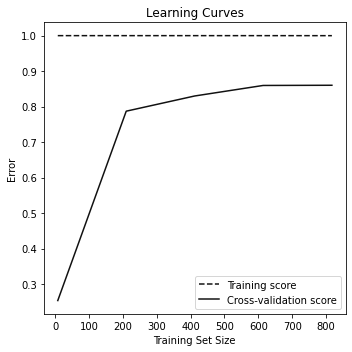

In [58]:
learning_curve_plot(xgb, X_train, y_train, scoring = 'r2')

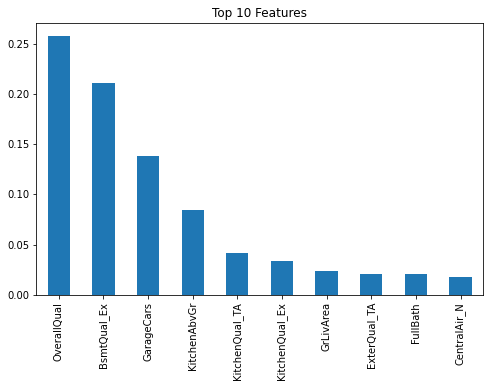

In [59]:
feature_importance_plot(xgb, X_train, n = 10)

Summary

- We selected three machine learning algorithms, predominantly decision tree based because of the distribution of the data (skewed data). 
- The Random Forest Model slightly outperformed the other models in terms of performance metrics (had the highest r2 and lowest MSE, MAE)
- However, when looking at the models in more detail, we saw signs of overfitting and signs of high variance, which was clear from the gap in the learning curves and the differences in metrics on the training and test set. This means the model is just memorising the data, and we can not trust it to generalise well to new data. 
- Next steps would include reducing the number features (we can do this by removing redundant features) and seeing if that shows any signs of improvements, and also some hyperparameter tuning. 

### Hyperparameter Tuning

In [60]:
RandomForestRegressor(n_estimators=500)

RandomForestRegressor()

In [64]:
# Let’s say we want to span the n_estimators hyperparameter from 100 to 500 with a step of 100 and the max_features hyperparameter from 0.1 to 1.0 with a step of 0.05. We are looking for the combination of these ranges that maximizes the average value of R2 in 5-fold cross-validation

params = {'n_estimators':np.arange(100,500,100),
          'max_features':np.arange(0.1,1.0,0.2)}

In [65]:
from sklearn.model_selection import GridSearchCV

# Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters. 
# It is an exhaustive search that is performed on a the specific parameter values of a model. 
# The model is also known as an estimator. Grid search exercise can save us time, effort and resources.

grid_search = GridSearchCV(rf,
                           params,
                           cv=5, 
                           scoring="r2",
                           verbose=1,
                           n_jobs=-1
                           )
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': array([0.1, 0.3, 0.5, 0.7, 0.9]),
                         'n_estimators': array([100, 200, 300, 400])},
             scoring='r2', verbose=1)

In [66]:
grid_search.best_params_

{'max_features': 0.30000000000000004, 'n_estimators': 200}

In [67]:
grid_search.best_score_

0.8786344868451617

In [68]:
# pass in the best parameters

rf_tuned = RandomForestRegressor(**grid_search.best_params_)
rf_tuned.fit(X_train, y_train)

RandomForestRegressor(max_features=0.30000000000000004, n_estimators=200)

In [69]:
# evaluation on unseen data

y_pred_rf = rf_tuned.predict(X_test)

r2 = r2_score(y_test, y_pred_rf)
print("R2:", round(r2, 2))
explained_var = explained_variance_score(y_test, y_pred_rf)
print("Explained Variance:", round(explained_var, 2))
mae = mean_absolute_error(y_test, y_pred_rf)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_test, y_pred_rf)
print("Mean Squared Error:", round(mse))

# reduction in the MAE and slight increase in R2

R2: 0.84
Explained Variance: 0.84
Mean Absolute Error: 16355
Mean Squared Error: 861384972


In [70]:
# the evaluation metrics for the model on the training set

y_pred_train_rf = rf_tuned.predict(X_train)

r2 = r2_score(y_train, y_pred_train_rf)
print("R2:", round(r2, 2))
explained_var = explained_variance_score(y_train, y_pred_train_rf)
print("Explained Variance:", round(explained_var, 2))
mae = mean_absolute_error(y_train, y_pred_train_rf)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_train, y_pred_train_rf)
print("Mean Squared Error:", round(mse))



R2: 0.98
Explained Variance: 0.98
Mean Absolute Error: 6228
Mean Squared Error: 109654104


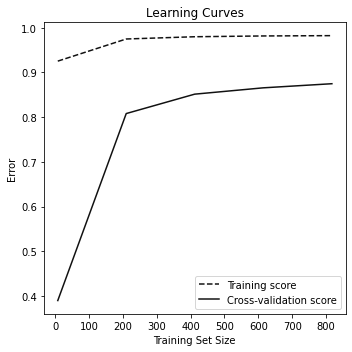

In [71]:
learning_curve_plot(rf_tuned, X_train, y_train, scoring = 'r2')

# model still overfitting need to do some tuning

In [68]:
from sklearn.model_selection import RandomizedSearchCV

# if Grid search is taking too long, can use Random search,
# Random search is a technique where random combinations of the hyperparameters are used to find the best solution for the built model. 
# The selection of parameters is completely random.

random_search = RandomizedSearchCV(rf,
                                   params,
                                   cv=5,
                                   scoring="r2",
                                   verbose=1,
                                   n_jobs=-1, 
                                   random_state = 0
                                  )
random_search.fit(X_train,y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                                        'n_estimators': array([100, 200, 300, 400])},
                   random_state=0, scoring='r2', verbose=1)

In [69]:
random_search.best_params_

# same as the Grid search

{'n_estimators': 300, 'max_features': 0.3500000000000001}

In [70]:
random_search.best_score_

# feel free to check if the parameters from the random search reduce overfitting

0.8789141436321589

### Removing Redundant Features

In [84]:
# identify least important feature based on a threshold

feat_importances = pd.Series(rf.feature_importances_,
                             index = X_train.columns)
feat_importance_df = pd.DataFrame(feat_importances).sort_values(by = 0).reset_index().rename(columns = {'index': 'feature',
                                                                                        0: 'score'})
feats_to_drop = list(feat_importance_df[feat_importance_df.score < 0.01].feature)
print(feats_to_drop)

['ExterCond_Po', 'Utilities_NoSeWa', 'HeatingQC_Po', 'Utilities_AllPub', 'ExterCond_Ex', 'LotConfig_FR3', 'Street_Pave', 'Street_Grvl', 'BsmtCond_Po', 'BldgType_2fmCon', 'ExterQual_Fa', 'MasVnrType_BrkCmn', 'BsmtQual_Unknown', 'BldgType_Twnhs', 'LandContour_Low', 'MSZoning_RH', 'KitchenQual_Fa', 'BsmtCond_Unknown', 'MiscVal', 'MasVnrType_Unknown', 'BldgType_TwnhsE', 'LandSlope_Sev', 'BsmtExposure_Unknown', 'LotConfig_FR2', 'LotShape_IR2', 'PavedDrive_P', '3SsnPorch', 'PavedDrive_N', 'ExterCond_Fa', 'BsmtQual_Fa', 'GarageFinish_Unknown', 'BsmtCond_Fa', 'ExterCond_Gd', 'PavedDrive_Y', 'BldgType_Duplex', 'MSZoning_FV', 'BsmtCond_Gd', 'HeatingQC_Fa', 'BsmtExposure_Mn', 'LotShape_IR3', 'ExterCond_TA', 'ExterQual_Ex', 'LandSlope_Mod', 'LowQualFinSF', 'BldgType_1Fam', 'BsmtExposure_Av', 'HeatingQC_Gd', 'BsmtQual_TA', 'LotConfig_CulDSac', 'BsmtCond_TA', 'LandContour_HLS', 'MSZoning_C (all)', 'HeatingQC_TA', 'LotShape_IR1', 'LandSlope_Gtl', 'HeatingQC_Ex', 'LandContour_Bnk', 'BsmtFinSF2', 'Pool

In [85]:
# define the target and features

print(features.shape)
features.drop(feats_to_drop, axis = 1, inplace = True) # drop redundant features
print(features.shape)

(1460, 112)
(1460, 9)


In [86]:
X_train, X_test, y_train, y_test = train_test_split(
                                                features, 
                                                target,
                                                test_size = 0.3, 
                                                random_state = 8)


In [87]:
# Build a Random Forest Model

rf_wout_redundant_features = RandomForestRegressor()
rf_wout_redundant_features.fit(X_train, y_train)
y_pred_rf = rf_wout_redundant_features.predict(X_test)

In [88]:
# evaluation on unseen data

y_pred_rf = rf_wout_redundant_features.predict(X_test)

r2 = r2_score(y_test, y_pred_rf)
print("R2:", round(r2, 2))
explained_var = explained_variance_score(y_test, y_pred_rf)
print("Explained Variance:", round(explained_var, 2))
mae = mean_absolute_error(y_test, y_pred_rf)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_test, y_pred_rf)
print("Mean Squared Error:", round(mse))


R2: 0.8
Explained Variance: 0.8
Mean Absolute Error: 19149
Mean Squared Error: 1060682637


In [89]:
# the evaluation metrics for the model on the training set

y_pred_train_rf = rf_wout_redundant_features.predict(X_train)

r2 = r2_score(y_train, y_pred_train_rf)
print("R2:", round(r2, 2))
explained_var = explained_variance_score(y_train, y_pred_train_rf)
print("Explained Variance:", round(explained_var, 2))
mae = mean_absolute_error(y_train, y_pred_train_rf)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_train, y_pred_train_rf)
print("Mean Squared Error:", round(mse))


R2: 0.98
Explained Variance: 0.98
Mean Absolute Error: 7143
Mean Squared Error: 137679560


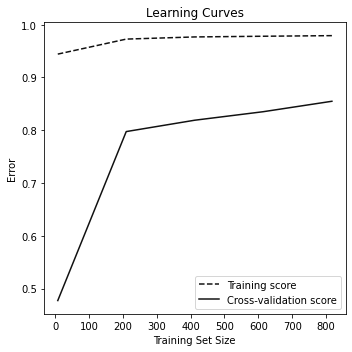

In [90]:
learning_curve_plot(rf_wout_redundant_features, X_train, y_train, scoring = 'r2')

In [91]:
# could tune the model with the removed redundant features to see if this would reduce overfitting